In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [ ]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

In [ ]:
# Distribute it to train and test set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170508288/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


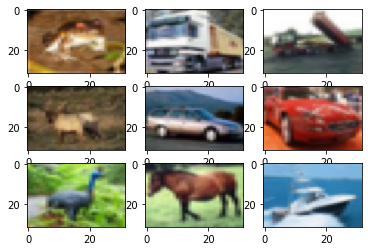

In [ ]:
# visualize data by plotting images
fig, ax = plt.subplots(3, 3)
k = 0
 
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(x_train[k], aspect='auto')
        k += 1
 
plt.show()

In [ ]:
# Concatenate train and test images
X = np.concatenate((x_train,x_test))
y = np.concatenate((y_train,y_test))

# Check shape
print(X.shape) # (60000, 32, 32, 3)

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=12000, random_state=1234)
# Check shape
print(x_train.shape) # (48000, 32, 32, 3)

(60000, 32, 32, 3)
(48000, 32, 32, 3)


We have made a split of 80-20 on the dataset. The shape of x refers to the number of samples, 32 x 32 pixels in each image and 3 refers to the RGB values. 

In [ ]:
x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])

We convert the images to grayscale which refer to making the 3 element RGB into a 1 element Grayscale value.

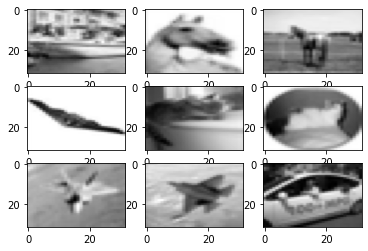

In [ ]:
# visualize data by plotting images
fig, ax = plt.subplots(3, 3)
k = 0
 
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(x_train[k], aspect='auto', cmap = 'gray')
        k += 1
 
plt.show()

In [ ]:
# Reduce pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0
# flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()
# Check shape
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(48000, 32, 32) (48000,) (12000, 32, 32) (12000,)


Here we are normalizing the x values between 0 to 255 into between 0 to 1 and flattening the y values.

In [ ]:
nsamples, nx, ny = x_train.shape
x_train2 = x_train.reshape((nsamples,nx*ny))
nsamples2, nx2, ny2 = x_test.shape
x_test2 = x_test.reshape((nsamples2,nx2*ny2))

We reshape the 32 x 32 matrix into a vector of 1024 elements since the GaussianNB function and GMM function take the x values as an 1D array. 

In [ ]:
class GMM:
    def __init__(self, n_components, max_iter = 100, comp_names=None):
        self.n_componets = n_components
        self.max_iter = max_iter
        if comp_names == None:
            self.comp_names = [f"comp{index}" for index in range(self.n_componets)]
        else:
            self.comp_names = comp_names
        # pi list contains the fraction of the dataset for every cluster
        self.pi = [1/self.n_componets for comp in range(self.n_componets)]

    def multivariate_normal(self, X, mean_vector, covariance_matrix):
        return (2*np.pi)**(-len(X)/2)*np.linalg.det(covariance_matrix)**(-1/2)*np.exp(-np.dot(np.dot((X-mean_vector).T, np.linalg.inv(covariance_matrix)), (X-mean_vector))/2)

    def fit(self, X):
        # Spliting the data in n_componets sub-sets
        new_X = np.array_split(X, self.n_componets)
        # Initial computation of the mean-vector and covarience matrix
        self.mean_vector = [np.mean(x, axis=0) for x in new_X]
        self.covariance_matrixes = [np.cov(x.T) for x in new_X]
        # Deleting the new_X matrix because we will not need it anymore
        del new_X
        for iteration in range(self.max_iter):
            ''' --------------------------   E - STEP   -------------------------- '''
            # Initiating the r matrix, evrey row contains the probabilities
            # for every cluster for this row
            self.r = np.zeros((len(X), self.n_componets))
            # Calculating the r matrix
            for n in range(len(X)):
                for k in range(self.n_componets):
                    self.r[n][k] = self.pi[k] * self.multivariate_normal(X[n], self.mean_vector[k], self.covariance_matrixes[k])
                    self.r[n][k] /= sum([self.pi[j]*self.multivariate_normal(X[n], self.mean_vector[j], self.covariance_matrixes[j]) for j in range(self.n_componets)])
            # Calculating the N
            N = np.sum(self.r, axis=0)
            ''' --------------------------   M - STEP   -------------------------- '''
            # Initializing the mean vector as a zero vector
            self.mean_vector = np.zeros((self.n_componets, len(X[0])))
            # Updating the mean vector
            for k in range(self.n_componets):
                for n in range(len(X)):
                    self.mean_vector[k] += self.r[n][k] * X[n]
            self.mean_vector = [1/N[k]*self.mean_vector[k] for k in range(self.n_componets)]
            # Initiating the list of the covariance matrixes
            self.covariance_matrixes = [np.zeros((len(X[0]), len(X[0]))) for k in range(self.n_componets)]
            # Updating the covariance matrices
            for k in range(self.n_componets):
                self.covariance_matrixes[k] = np.cov(X.T, aweights=(self.r[:, k]), ddof=0)
            self.covariance_matrixes = [1/N[k]*self.covariance_matrixes[k] for k in range(self.n_componets)]
            # Updating the pi list
            self.pi = [N[k]/len(X) for k in range(self.n_componets)]
    def predict(self, X):
        probas = []
        for n in range(len(X)):
            probas.append([self.multivariate_normal(X[n], self.mean_vector[k], self.covariance_matrixes[k])
                           for k in range(self.n_componets)])
        cluster = []
        for proba in probas:
            cluster.append(self.comp_names[proba.index(max(proba))])
        return cluster

The GMM model has been implemented from scratch here. n_components is the number of clusters we want to split the data into and max_iter is the number of iterations allowed. comp_names refers to the names of the clusters. 

The fit function splits the dataset into n subsets and the means and covariances of each list are added to the lists respectively. 

**E Step**:  
r matrix refers to the "responsibilities". Rows are the samples from the dataset, while columns represent every cluster, the elements of this matrix are interpreted as follows rnk is the probability of sample n to be part of cluster k. 

Multivariate Normal is calculated using a function. 

**M Step:**  
Setting the mean and covariance matrices step by step until convergence using the formulae derived in class. 

In the predict function we use the multivariate normal function with the optimal mean vectors and covariance matrices for each cluster, to find using which gives the biggest values.

In [ ]:
x_train2.shape

(48000, 1024)

In [ ]:
classifier2 = GMM(2)
classifier2.fit(x_train2)

In [ ]:
classifier = GaussianNB()
classifier.fit(x_train2, y_train)

GaussianNB()

In [ ]:
y_pred  =  classifier.predict(x_test2)
y_pred

array([0, 6, 5, ..., 8, 2, 0], dtype=uint8)

In [ ]:
y_test

array([8, 3, 3, ..., 8, 2, 4], dtype=uint8)

In [ ]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.46      0.25      0.32      2205
           1       0.10      0.32      0.16       392
           2       0.08      0.18      0.11       512
           3       0.08      0.24      0.12       415
           4       0.41      0.21      0.28      2295
           5       0.23      0.33      0.27       847
           6       0.40      0.21      0.28      2300
           7       0.11      0.45      0.18       285
           8       0.43      0.34      0.38      1534
           9       0.40      0.39      0.40      1215

    accuracy                           0.27     12000
   macro avg       0.27      0.29      0.25     12000
weighted avg       0.36      0.27      0.29     12000



In [ ]:
accuracy_score(y_pred,y_test)

0.26916666666666667

In [ ]:
confusion_matrix(y_pred,y_test)

array([[542, 143, 271, 229, 146, 170, 156, 175, 241, 132],
       [ 25, 127,  15,  38,   4,  33,  12,  31,  27,  80],
       [ 41,  32,  92,  73,  66,  60,  44,  53,  25,  26],
       [  5,  34,  27, 101,  44,  81,  20,  53,  27,  23],
       [141,  97, 381, 186, 490, 222, 353, 282,  79,  64],
       [ 33,  77,  27, 145,  43, 276,  40,  90,  88,  28],
       [ 82, 318, 261, 302, 279, 209, 486, 132, 101, 130],
       [  7,  24,  10,  29,  11,  33,   9, 127,   9,  26],
       [240, 161,  70,  69,  78,  68,  40,  96, 515, 197],
       [ 75, 209,  49,  62,  40,  49,  50, 114,  93, 474]])

The Gaussian Naive Bayes implementation from sci-kit learn gives us a testing accuracy of around 27 % which means it's not a good classifier for this dataset. 